In [1]:
%load_ext autoreload
%autoreload 2

%env CUDA_VISIBLE_DEVICES 0

env: CUDA_VISIBLE_DEVICES=0


In [2]:
import sys

sys.path.insert(0, '../batchflow')
sys.path.insert(0, '../src')

import numpy as np
import pandas as pd
import lightgbm as lgb

from batchflow import Pipeline, B, plot
from batchflow.models.torch import TorchModel
from sklearn.decomposition import PCA
from nbtools.core import get_notebook_name

from batchflow.models.metrics import ClassificationMetrics

from loader import ImagesDataset

In [3]:
NAME = get_notebook_name()
NAME

'05_LGBM'

In [4]:
SEED = 11
rng = np.random.default_rng(SEED)

In [5]:
DATA_PATH = '../images'
SHAPE = (128, 128, 3)

dataset = ImagesDataset(path=DATA_PATH, encode_labels=True, normalize=True, resize_shape=SHAPE)
n_classes = dataset.label_encoder.classes_.size

dataset.split(shuffle=SEED)

100%|█████████████████████████████████████████████| 9/9 [00:17<00:00,  1.96s/it]


In [6]:
%%time

MODEL_PATH = '../models/vgg.torch'
model = TorchModel()
model.load(MODEL_PATH)
penultimate_module = model.model[1][-2]

CPU times: user 1.31 s, sys: 709 ms, total: 2.02 s
Wall time: 2.02 s


## 

In [7]:
%%time

predict_template = (
    Pipeline()
    # prepare data
    .to_array(channels='first', dtype=np.float32)

    # initialize prediction and metrics containers
    .init_variables('images', 'labels', 'proba', 'predictions', 'metrics')
    
    # import trained model
    .import_model('model', model)
    
    # make predictions
    .predict_model(name='model', inputs=B('images'),
                   outputs=['predictions', 'predicted_proba'], save_to=[B('predictions'), B('proba')])
    
    # get penultimate layer activations
    .call(model.get_intermediate_activations, inputs=B('images'),
          layers=penultimate_module, save_to=B('activations'))
)

predict_pipeline_train = predict_template << dataset.train
train_batch = predict_pipeline_train.next_batch(dataset.train.size)

CPU times: user 796 ms, sys: 1.01 s, total: 1.81 s
Wall time: 8.51 s


In [8]:
%%time

n_features = 100
pca = PCA(n_components=n_features, random_state=SEED)
train_features = train_batch.activations.reshape(dataset.train.size, -1)
train_features_reduced = pca.fit_transform(train_features)
train_data = lgb.Dataset(data=train_features_reduced, label=train_batch.labels)

CPU times: user 3min 37s, sys: 4min 2s, total: 7min 40s
Wall time: 10.9 s


In [9]:
%%time

predict_pipeline_test = predict_template << dataset.test
test_batch = predict_pipeline_test.next_batch(dataset.test.size)
test_features = test_batch.activations.reshape(dataset.test.size, -1)
test_features_reduced = pca.transform(test_features)
test_data = lgb.Dataset(data=test_features_reduced, label=test_batch.labels)

CPU times: user 6.85 s, sys: 1.97 s, total: 8.81 s
Wall time: 2.66 s


In [10]:
train_config = {
    'num_leaves': 16,
    'max_depth': 5,
    'min_data_in_leaf': 20,
    'objective': 'multiclass',
    'num_class': n_classes,
    'verbose': -1,
}

num_round = 50

model = lgb.train(
    params=train_config,
    train_set=train_data,
    num_boost_round=num_round,
    valid_sets=[test_data],
    verbose_eval=False
)

In [11]:
prediction = model.predict(test_features_reduced)
predicted_labels = prediction.argmax(axis=1)

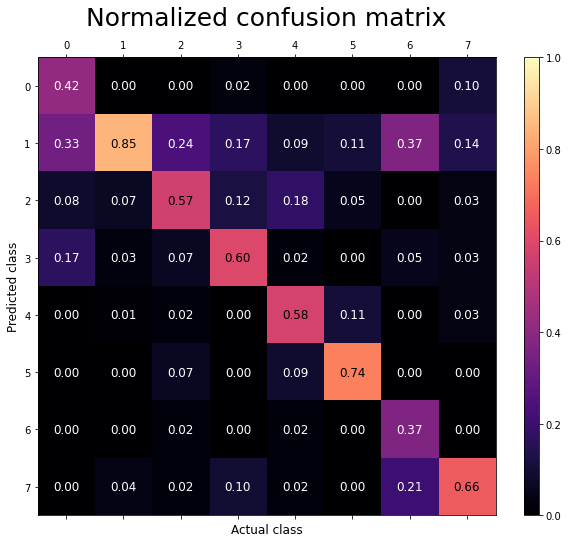

In [12]:
metrics = ClassificationMetrics(test_batch.labels, predicted_labels, fmt='labels', num_classes=n_classes)
metrics.plot_confusion_matrix(normalize=True, vmin=0, vmax=1)

In [13]:
labels, counts = np.unique(dataset.labels[dataset.train.indices], return_counts=True)
shares = counts / counts.sum()

metrics_names = ['precision', 'recall']
metrics_dict = metrics.evaluate(metrics_names, multiclass=None)
metrics_df = pd.DataFrame({'names': dataset.label_encoder.classes_, 'counts': counts, 'shares': shares, **metrics_dict})

formatter = lambda value: f"{int(value * 100)}%"
metrics_df.style.background_gradient('RdYlGn', vmin=0, vmax=1, subset=metrics_names).format(formatter, subset=metrics_names)

,names,counts,shares,precision,recall
0,ArtDeco,53,0.046573,55%,41%
1,Cubism,293,0.257469,61%,84%
2,Impressionism,194,0.170475,55%,56%
3,Japonism,161,0.141476,71%,59%
4,Naturalism,173,0.152021,83%,57%
5,Rococo,98,0.086116,66%,73%
6,cartoon,56,0.049209,77%,36%
7,photo,110,0.096661,59%,65%


In [14]:
metrics_names = ['accuracy', 'f1_score']
metrics_values = [metrics.evaluate(metric_name) for metric_name in metrics_names]

metrics_df = pd.DataFrame(data=metrics_values, index=metrics_names)
metrics_df.T.style.background_gradient('RdYlGn', vmin=0, vmax=1).format(formatter)

,accuracy,f1_score
0,64%,62%


In [15]:
METRICS_PATH = f'../metrics/{NAME}.npy'
all_metrics = {**metrics_dict, **{key: value for key, value in zip(metrics_names, metrics_values)}}
# np.save(METRICS_PATH, all_metrics)

In [16]:
# labels = dataset.label_encoder.inverse_transform(batch.labels)
# for cluster_num in range(n_classes):
#     cluster_images = batch.images[clustered == cluster_num]
#     cluster_images = list(cluster_images.transpose(0, 2, 3, 1))
#     cluster_true_labels = labels[clustered == cluster_num].tolist()
#     plot(cluster_images, title=cluster_true_labels, suptitle=f"cluster: {cluster_num}", suptitle_y=1, suptitle_size=30, combine='separate')